In [121]:
import requests
from bs4 import BeautifulSoup
import bs4
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
from io import BytesIO
import re
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g
import datetime
from selenium.webdriver.chrome.options import Options
import numpy as np
import random
from selenium.webdriver import ActionChains
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings
import itertools
import math
from fbprophet import Prophet
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

Importing plotly failed. Interactive plots will not work.


In [3]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if "," in x:
        x = x.replace(',', '')
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'T' in x:
        if len(x) > 1:
            return float(x.replace('T', '')) * 1000000000
        return 1000000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return float(x)

In [4]:
def prepareData():
    scope = ['https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name("../creds.json", scope)
    client = gspread.authorize(creds)
    sheet = client.open("stock data")
    sheet = sheet.worksheet("crypto")
    df = pd.DataFrame(sheet.get_all_values())
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df = df.replace('N/A', np.nan)
    df= df.dropna()
    scope = ['https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name("../creds.json", scope)
    client = gspread.authorize(creds)
    sheet = client.open("stock data1")
    sheet = sheet.worksheet("crypto")
    df1 = pd.DataFrame(sheet.get_all_values())
    df1.columns = df1.iloc[0]
    df1 = df1.iloc[1:]
    df1 = df1.replace('N/A', np.nan)
    df1= df1.dropna()
    allData = df.append(df1)
    allData = allData.reset_index()
    allData = allData.drop(columns = ['index'])
    df = allData
    df["Total Volume All Currencies (24Hr)"] = [value_to_float(x) for x in df["Total Volume All Currencies (24Hr)"]]
    df["Volume in Currency (Since 0:00 UTC)"] = [value_to_float(x) for x in df["Volume in Currency (Since 0:00 UTC)"]]
    df["Volume in Currency (24Hr)"] = [value_to_float(x) for x in df["Volume in Currency (24Hr)"]]
    df['Circulating Supply'] = [value_to_float(x) for x in df['Circulating Supply']]
    df['52 Week Range'] = [value_to_float(x) for x in df['52 Week Range']]
    df['Change'] = [s.replace(',', '').replace('+', '') for s in df['Change']]
    df["Price (Intraday)"] = [s.replace(',', '') for s in df["Price (Intraday)"]]
    df['time'] = [datetime.datetime.strptime(s[4:], '%b %d %H:%M:%S %Y') for s in df['time']]
    df = df.astype({'Change': float, "Price (Intraday)": float, "Total Volume All Currencies (24Hr)": float, "Volume in Currency (Since 0:00 UTC)": float, "Volume in Currency (24Hr)": float, 'Circulating Supply':float,'52 Week Range': float})
    df = df.drop(columns = '% Change')
    df['day of week'] = [t.weekday() for t in df['time']]
    df['hour of day'] = [t.hour for t in df['time']]
    df = df[df['hour of day'] != 22]
    df['timedelta'] = [(datetime.datetime.now() - x).total_seconds() for x in df['time']]
    df['6 hour diff'] = df.groupby('Symbol')['Price (Intraday)'].diff() * -1
    df['% 6 hour diff'] = df['6 hour diff']/ (df['Price (Intraday)'] - df['6 hour diff']) * 100
    oneHotDOW = pd.get_dummies(df['day of week'],prefix='dow')
    oHDOWcols = oneHotDOW.columns
    df[list(oHDOWcols)] = oneHotDOW
    oneHotHOD = pd.get_dummies(df['hour of day'],prefix='hod')
    oHHODcols = oneHotHOD.columns
    df[list(oHHODcols )] = oneHotHOD
    dfNoOH = df.iloc[:,:15]
    df = df.drop(columns = 'hour of day')
    df = df.drop(columns = 'day of week')
    return dfNoOH, df

In [137]:
def plotBreakdown(data):
    data = data.drop(columns = 'hour of day')
    data= data.drop(columns = 'day of week')
    data = dfNoOH[dfNoOH['Symbol'] == 'ETH-USD']
    data = data.sort_values('time')
    data = data.groupby('time')['Price (Intraday)'].sum().reset_index()
    data = data.set_index('time')
    y = data.resample('6h').mean()
    ps =list(y['Price (Intraday)'])
    x = 5
    newPs = []
    for x in range(len(list(y['Price (Intraday)']))):
        if math.isnan(ps[x]):
            newPs.append(np.nanmean(ps[x - 5:x + 5]))
        else:
            newPs.append(ps[x])
    y['Price (Intraday)'] = newPs
    y = y.reset_index()
    y = y.rename(columns={'time':'ds', 'Price (Intraday)':'y'})
    b = y
    model = Prophet(interval_width=0.95)
    model.fit(b)
    
    forecast = model.make_future_dataframe(periods=36, freq='6h')
    forecast = model.predict(forecast)
    model.plot_components(forecast);
    plt.show()

In [126]:
def predictArima(data, start_date):

    data = data.drop(columns = 'hour of day')
    data= data.drop(columns = 'day of week')
    data = dfNoOH[dfNoOH['Symbol'] == 'ETH-USD']
    data = data.sort_values('time')
    data = data.groupby('time')['Price (Intraday)'].sum().reset_index()
    data = data.set_index('time')
    y = data.resample('6h').mean()
    ps =list(y['Price (Intraday)'])
    x = 5
    newPs = []
    for x in range(len(list(y['Price (Intraday)']))):
        if math.isnan(ps[x]):
            newPs.append(np.nanmean(ps[x - 5:x + 5]))
        else:
            newPs.append(ps[x])
    y['Price (Intraday)'] = newPs
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=(0, 0, 1),
                                    seasonal_order=(1, 2, 3, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    pred = results.get_prediction(start=pd.to_datetime('2020-11-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = y[start_date:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

In [119]:
def predictFutureARIMA(data):
    data = data.drop(columns = 'hour of day')
    data= data.drop(columns = 'day of week')
    data = dfNoOH[dfNoOH['Symbol'] == 'ETH-USD']
    data = data.sort_values('time')
    data = data.groupby('time')['Price (Intraday)'].sum().reset_index()
    data = data.set_index('time')
    y = data.resample('6h').mean()
    ps =list(y['Price (Intraday)'])
    x = 5
    newPs = []
    for x in range(len(list(y['Price (Intraday)']))):
        if math.isnan(ps[x]):
            newPs.append(np.nanmean(ps[x - 5:x + 5]))
        else:
            newPs.append(ps[x])
    y['Price (Intraday)'] = newPs
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=(0, 0, 1),
                                    seasonal_order=(1, 2, 3, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    pred = results.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
    pred_ci = pred.conf_int()

    y_forecasted = pred.predicted_mean
    y_truth = y['2020-07-01':]
    mse = ((y_forecasted.tolist() - y_truth['Price (Intraday)']) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
    pred_uc = results.get_forecast(steps=15)
    pred_ci = pred_uc.conf_int()
    ax = y[1200:].plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

In [83]:
def knn(data, k, test_size, train_size, guess, q):
    bins = q
    qs = list(data['% 6 hour diff'].quantile(np.linspace(0,1, bins + 1)[1:bins]))
    qs
    quartile = []
    for x in data['% 6 hour diff']:
        for i in range(bins):
            if i == bins -1:
                quartile.append(i)
                break
            if x < qs[i]:
                quartile.append(i)
                break 
    data['quartile'] = quartile
    data = data.drop(columns = 'time')
    test = data.drop(columns = ['Name', 'Symbol'])
    if not guess:
        test = test.dropna()
    X = test.drop(columns = ['% 6 hour diff', '6 hour diff'])
    y = test['quartile'].astype(int)
    scaler = StandardScaler() 
    X = scaler.fit_transform(X)
    X_train = X[test_size:test_size + train_size]
    X_test = X[:test_size]
    y_train = y[test_size:test_size + train_size]
    y_test = y[:test_size]
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred, y_test, qs

In [97]:
def knnAllData(data):
    allResults = pd.DataFrame()
    for q in range(2, 15):
        p, t, qs = knn(data, 10, 30, 10000, True,q)
        results = data.iloc[:15]
        results['bins'] = [q] * 15
        results['guess'] = p[:15]
        maxProjs = []
        maxVals = []
        for i in range(len(results['guess'])):
            guess = round(results['guess'][i],2)
            currVal = round(results['Price (Intraday)'][i],2)
            if guess == 0:
                maxP = 'x < ' + str(round(qs[guess], 2))
                maxVal = 'x < ' + str(round(qs[guess]/100 * currVal + currVal,2)) 
            elif guess == q - 1:
                maxP =  str(round(qs[guess -1], 2)) + ' < x'
                maxVal= str(round(qs[guess -1]/100 * currVal + currVal, 2)) + ' < x'
            else:
                maxP = str(round(qs[guess - 1], 2)) + ' < ' + ' x ' + ' < ' + str(round(qs[guess],2))
                maxVal = str(round(qs[guess - 1]/100 * currVal + currVal, 2)) + ' < ' + ' x ' + ' < ' + str(round(qs[guess]/ 100 * currVal + currVal, 2))
            maxVals.append(maxVal)
            maxProjs.append(maxP)
        results['max value'] = maxVals
        results['max %'] = maxProjs
        allResults = allResults.append(results[['Symbol','Name','Price (Intraday)','bins', 'guess', 'max %','max value']])
    keep = []
    for x in allResults['Symbol']:
        if x in rbh:
            keep.append(True)
        else:
            keep.append(False)
    allResults = allResults[keep]
    allResults = allResults.sort_values(['Symbol', 'bins'])
    return allResults

In [107]:
def knnTrainedonEachCoin(df):
    scores = pd.DataFrame(columns=['Symbol', 'Current Price', "bins", "average accuracy",'guess',"max %",'max value','true positive rate','pred > true','pred < true','pred < q0'])
    for symbol in rbh:
        data = df[df['Symbol'] == symbol]
        currVal = list(data['Price (Intraday)'])[0]
        for x in range(2,18):
            bins = x
            samples = 800
            if symbol == 'BSV-USD':
                samples = 120
            train_size = 248
            test_size = 2
            k = 10
            p1 = []
            t1 = []
            for y in range(1, samples):
                test = data.iloc[y:]
                p, t, bb = knn(test, k, test_size, train_size, False, x)
                p1.append(p[0])
                t1.append(t.iloc[0])
            avgr2 = metrics.accuracy_score(t1,p1)
            predss = pd.DataFrame({'y_pred':p1, 'y_test':t1, '% 6 hour diff' : list(data['% 6 hour diff'])[1:len(p1)+1]})
            tp = 0
            pGt = 0
            pLt = 0
            pG0 = 0
            p, t, qs = knn(data, k, test_size, train_size, True, x)
            for i in range(len(qs)):
                if qs[i] > 0:
                    qInd = i
                    break
            guess = list(p)[0]
            predsProj = pd.DataFrame({'y_pred':p1, 'y_test':t1})
            predss = predss[predss['y_pred'] == guess]
            for i in range(len(predss['y_pred'])):
                pred = list(predss['y_pred'])[i]
                test = list(predss['y_test'])[i]
                if pred == test:
                    tp += 1
                elif pred > test:
                    pGt += 1
                elif pred < test:
                    pLt += 1
                    if pred <= qInd:
                        pG0 += 1
            if guess == 0:
                maxP = 'x < ' + str(qs[guess]) 
            elif guess == bins - 1:
                maxP =  str(qs[guess -1]) + ' < x'
            else:
                maxP = str(qs[guess - 1]) + ' < ' + ' x ' + ' < ' + str(qs[guess])
            if guess == 0:
                maxVal = 'x < ' + str(qs[guess]/100 * currVal + currVal) 
            elif guess == bins - 1:
                maxVal= str(qs[guess -1]/100 * currVal + currVal) + ' < x'
            else:
                maxVal = str(qs[guess - 1]/100 * currVal + currVal) + ' < ' + ' x ' + ' < ' + str(qs[guess]/ 100 * currVal + currVal)
            scores = scores.append({'Symbol': symbol,
                                    'Current Price': currVal,
                                'bins': bins,
                                "average accuracy": avgr2,
                                    'guess' : guess,
                                   "max %": maxP,
                                   'max value' : maxVal,
                                   'true positive rate': tp,
                                   'pred > true': pGt,
                                   'pred < true': pLt,
                                   'pred < q0': pG0,
                                   'q0': qs[qInd]}, ignore_index=True)
    return scores
    

In [108]:
def plotRealvsPredAdaBoost(symbol):
    data = dfNoOH[dfNoOH['Symbol'] == symbol]
    data = data.sort_values('time')
    data = data.set_index('time')
    data = data.drop(columns=['Change', 'timedelta', '6 hour diff', '% 6 hour diff'])
    steps_ahead = 1
    cols = ['Price (Intraday)', 'Volume in Currency (Since 0:00 UTC)', 'Volume in Currency (24Hr)',
           'Total Volume All Currencies (24Hr)', 'Circulating Supply',
           '52 Week Range']
    sa = steps_ahead
    data = data[cols]
    for col in cols:
        data['log_' + col] = np.log(data[col])
    n = 3
    for i in range(n):
        for col in cols:
            data[col + '_lag_' + str(i+sa)] = data[col].shift(i+sa)
            data.dropna(inplace=True)
            data['log_' + col + '_lag_' + str(i+sa)] = np.log(data[col + '_lag_' + str(i+sa)])
            if i == 0:
                data['log_' + col + '_difference_' + str(i+sa)] = data['log_' + col] - data['log_' + col + '_lag_' + str(i+sa)]
            else:
                data['log_' + col + '_difference_' + str(i+sa)] = data['log_' + col + '_lag_' + str(i+sa - 1)] - data['log_' + col + '_lag_' + str(i+sa)]
    inclCols = cols
    newCols = []
    for col in inclCols:
        for i in range(sa+1,n+sa):
            newCols.append('log_' + col + '_difference_' + str(i))
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import AdaBoostRegressor
    X, Y = data[newCols], data['log_Price (Intraday)_difference_' + str(sa)]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)
    mdl_adaboost = AdaBoostRegressor(n_estimators=500, learning_rate=0.05)
    mdl_adaboost.fit(X_train, Y_train)
    pred = mdl_adaboost.predict(X_test)
    test_size = X_test.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    test_size = X_test.shape[0]
    plt.plot(data.tail(test_size).index, np.exp(data.tail(test_size)['log_Price (Intraday)_lag_' + str(sa)]  + pred), label='predicted', color='red')
    plt.plot(data.tail(test_size).index, data.tail(test_size)['Price (Intraday)'], label='real', color='blue')
    plt.legend(loc='best')
    ax.xaxis.set_tick_params(rotation=90, labelsize=10)
    plt.title('Predicted vs Real with log difference values')
    plt.show()

In [111]:
def timeSeriesPred(symbol, depth, cols, includeDOWHOD, oneHot, ne, lr):
    if oneHot:
        data = df[df['Symbol'] == symbol]
    else:
        data = dfNoOH[dfNoOH['Symbol'] == symbol]
    data = data.sort_values('time')
    data = data.set_index('time')
    data = data.drop(columns=['Change', 'timedelta', '6 hour diff', '% 6 hour diff'])
    data
    if includeDOWHOD:
        if oneHot:
            finalCols = cols + ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5','dow_6', 'hod_0', 'hod_6', 'hod_12', 'hod_18']
        else:
            finalCols = cols + ['day of week'] + ['hour of day']
    else:
        finalCols = cols
        
    data = data[finalCols]
    
    for col in cols:
        data['log_' + col] = np.log(data[col])
    
    n = depth
    for i in range(n):
        for col in cols:
            data[col + '_lag_' + str(i+1)] = data[col].shift(i+1)
            data.dropna(inplace=True)
            data['log_' + col + '_lag_' + str(i+1)] = np.log(data[col + '_lag_' + str(i+1)])

            data['log_' + col + '_difference_' + str(i+1)] = data['log_' + col] - data['log_' + col + '_lag_' + str(i+1)]

    inclCols = cols
    newCols = []
    for col in inclCols:
        for i in range(2,n+1):
            newCols.append('log_' + col + '_difference_' + str(i))  

    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_absolute_error
    
    X, Y = np.array(data[finalCols]), np.array(data['log_Price (Intraday)_difference_1'])

    tscv = TimeSeriesSplit(n_splits=5)

    data_log_sales_index = np.array(data.copy().reset_index()['log_Price (Intraday)_lag_1'])
    data_sales_index = np.array(data.copy().reset_index()['Price (Intraday)_lag_1'])

    metric_iter = {}
    for idx, val in enumerate(tscv.split(X)):
            train_i, test_i = val
            X_train, X_test = X[train_i], X[test_i]
            Y_train, Y_test = Y[train_i], Y[test_i]
            mdl_adaboost = AdaBoostRegressor(n_estimators=ne, learning_rate=lr)
            mdl_adaboost.fit(X_train, Y_train)
            pred = mdl_adaboost.predict(X_test)
            pred_untransform = [np.exp(val_test + val_pred) for val_test, val_pred in zip(data_log_sales_index[test_i], pred)]
            real = data_sales_index[test_i]
            metric_iter[f'iter_{idx + 1}'] = mean_absolute_error(real, pred_untransform)     
    mse = round(np.mean(list(metric_iter.values())),2)

    test = pd.DataFrame({'prior': list(real), 'pred':list(pred_untransform), 'actual': pd.Series(real).shift(sa)})
    accuracy = (sum((test['prior'] < test['pred']) & (test['prior'] < test['actual'])) + sum((test['prior'] >= test['pred']) & (test['prior'] >= test['actual']))) / len(test)

    newCols1 = []
    for col in inclCols:
        for i in range(1,n):
            newCols1.append('log_' + col + '_difference_' + str(i))
    valToPred = np.array(data[finalCols].iloc[-1])
    p1 = mdl_adaboost.predict(valToPred.reshape(-1, len(finalCols)))
    currPrice = str(data['Price (Intraday)'].iloc[-1])

    predPrice = str(round(np.exp(p1[0]) + data['Price (Intraday)'].iloc[-1], 2))

    return [symbol, mse, accuracy, depth, len(cols), includeDOWHOD, oneHot,ne, lr,currPrice, predPrice]

In [104]:
rbh = ['BTC-USD','ETH-USD']
cols = ['Price (Intraday)', 'Volume in Currency (Since 0:00 UTC)', '52 Week Range','Circulating Supply','Volume in Currency (24Hr)',
           'Total Volume All Currencies (24Hr)']

In [68]:
dfNoOH, df = prepareData()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


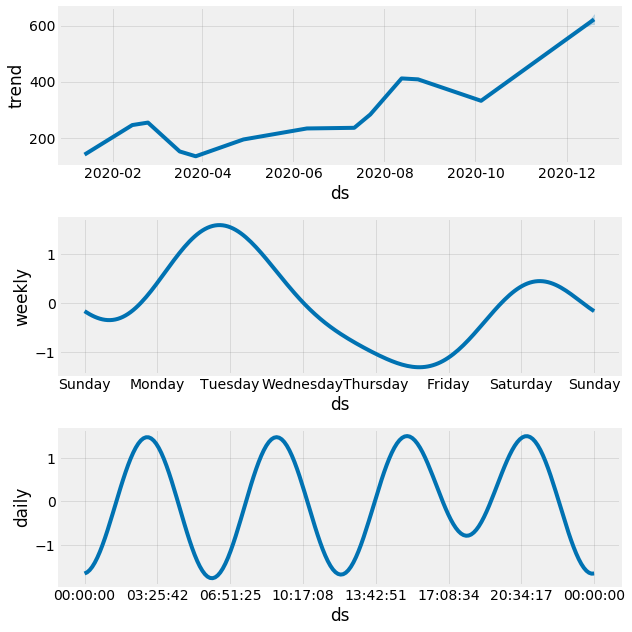

In [138]:
plotBreakdown(dfNoOH)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7757      0.012     63.508      0.000       0.752       0.800
ar.S.L12      -0.3426      0.469     -0.730      0.465      -1.262       0.577
ma.S.L12      -0.8644      0.485     -1.784      0.074      -1.814       0.085
ma.S.L24      -0.2693      0.561     -0.480      0.631      -1.368       0.830
ma.S.L36       0.1223      0.086      1.420      0.155      -0.046       0.291
sigma2       261.3229     10.128     25.803      0.000     241.473     281.173


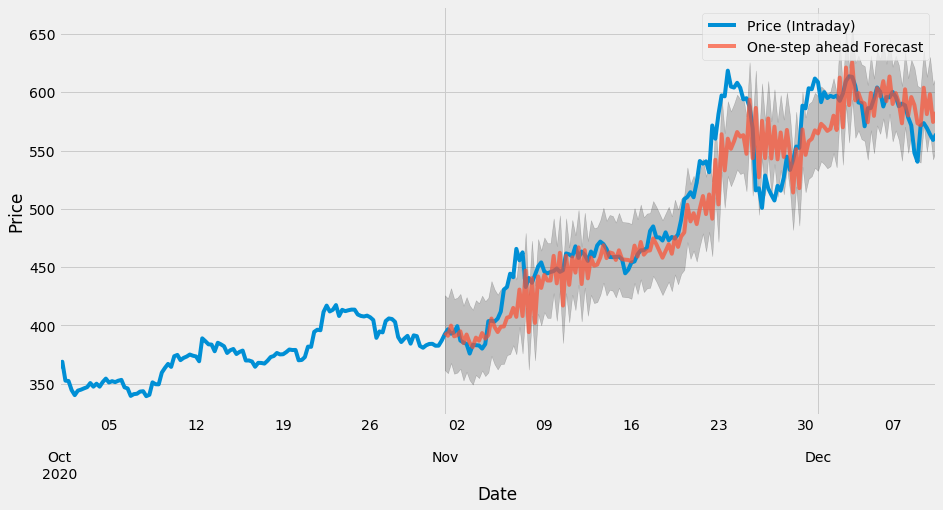

In [127]:
predictArima(dfNoOH, '2020-10-01')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7757      0.012     63.508      0.000       0.752       0.800
ar.S.L12      -0.3426      0.469     -0.730      0.465      -1.262       0.577
ma.S.L12      -0.8644      0.485     -1.784      0.074      -1.814       0.085
ma.S.L24      -0.2693      0.561     -0.480      0.631      -1.368       0.830
ma.S.L36       0.1223      0.086      1.420      0.155      -0.046       0.291
sigma2       261.3229     10.128     25.803      0.000     241.473     281.173


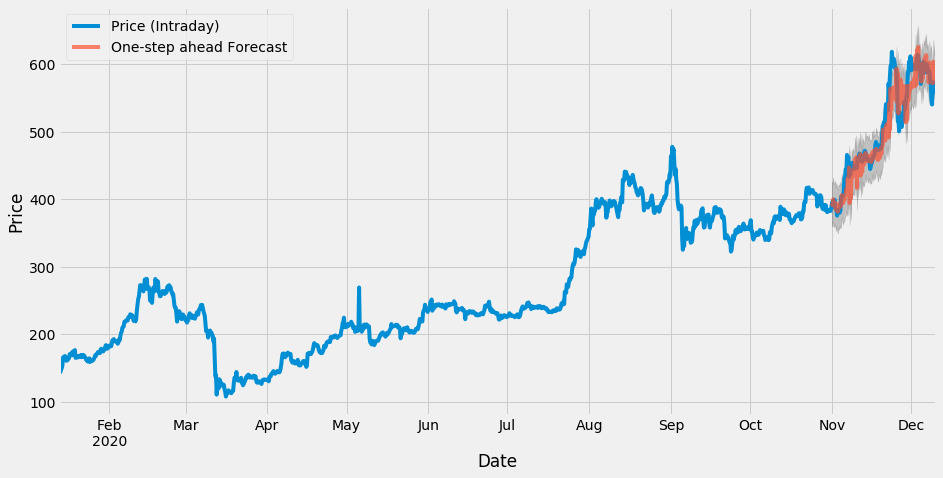

In [128]:
predictArima(dfNoOH, '2019-10-01')

The Mean Squared Error of our forecasts is 374.28
The Root Mean Squared Error of our forecasts is 19.35


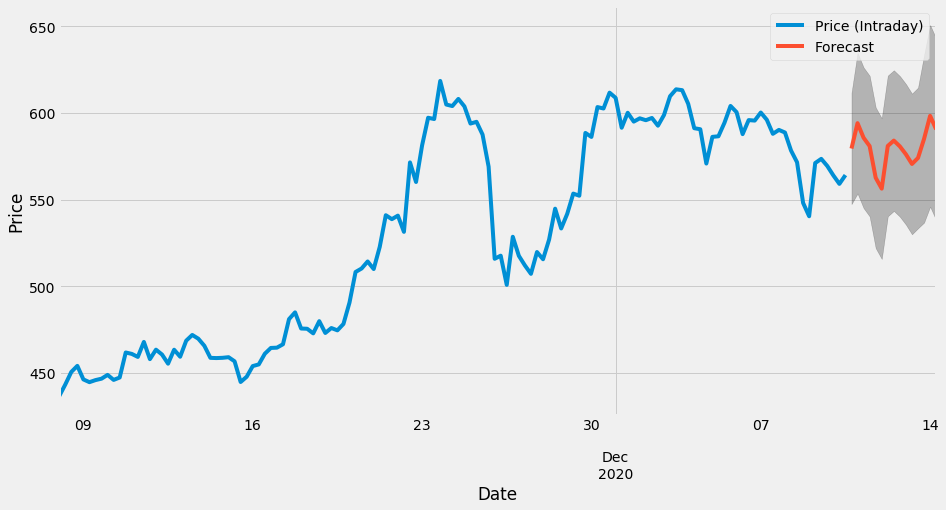

In [129]:
predictFutureARIMA(dfNoOH)

In [94]:
pd.set_option('display.max_rows', df.shape[0]+1)

In [105]:
knnAllData(dfNoOH)

,Symbol,Name,Price (Intraday),bins,guess,max %,max value
0,BTC-USD,Bitcoin USD,18377.54,2,1,0.01 < x,18378.87 < x
0,BTC-USD,Bitcoin USD,18377.54,3,1,-0.46 < x < 0.63,18293.77 < x < 18492.85
0,BTC-USD,Bitcoin USD,18377.54,4,2,0.01 < x < 1.08,18378.87 < x < 18575.78
0,BTC-USD,Bitcoin USD,18377.54,5,3,0.35 < x < 1.44,18441.35 < x < 18642.09
0,BTC-USD,Bitcoin USD,18377.54,6,2,-0.46 < x < 0.01,18293.77 < x < 18378.87
0,BTC-USD,Bitcoin USD,18377.54,7,4,0.24 < x < 0.86,18421.84 < x < 18536.31
0,BTC-USD,Bitcoin USD,18377.54,8,5,0.44 < x < 1.08,18458.53 < x < 18575.78
0,BTC-USD,Bitcoin USD,18377.54,9,5,0.19 < x < 0.63,18412.32 < x < 18492.85
0,BTC-USD,Bitcoin USD,18377.54,10,8,1.44 < x < 2.6,18642.09 < x < 18855.69
0,BTC-USD,Bitcoin USD,18377.54,11,9,1.6 < x < 2.78,18670.86 < x < 18888.03


In [106]:
knnAllData(df)

,Symbol,Name,Price (Intraday),bins,guess,max %,max value
0,BTC-USD,Bitcoin USD,18377.54,2,1,0.01 < x,18378.87 < x
0,BTC-USD,Bitcoin USD,18377.54,3,2,0.63 < x,18492.85 < x
0,BTC-USD,Bitcoin USD,18377.54,4,3,1.08 < x,18575.78 < x
0,BTC-USD,Bitcoin USD,18377.54,5,4,1.44 < x,18642.09 < x
0,BTC-USD,Bitcoin USD,18377.54,6,5,1.73 < x,18696.07 < x
0,BTC-USD,Bitcoin USD,18377.54,7,4,0.24 < x < 0.86,18421.84 < x < 18536.31
0,BTC-USD,Bitcoin USD,18377.54,8,5,0.44 < x < 1.08,18458.53 < x < 18575.78
0,BTC-USD,Bitcoin USD,18377.54,9,7,1.26 < x < 2.41,18608.74 < x < 18819.79
0,BTC-USD,Bitcoin USD,18377.54,10,8,1.44 < x < 2.6,18642.09 < x < 18855.69
0,BTC-USD,Bitcoin USD,18377.54,11,7,0.49 < x < 0.93,18468.22 < x < 18548.9


In [110]:
knnTrainedonEachCoin(df)

BTC-USD
ETH-USD


,Symbol,Current Price,bins,average accuracy,guess,max %,max value,true positive rate,pred > true,pred < true,pred < q0,q0
0,BTC-USD,18377.54,2,0.851064,1,0.10564502186879648 < x,18396.95495615195 < x,310,31,0,0,0.105645
1,BTC-USD,18377.54,3,0.614518,2,0.4200593760308287 < x,18454.736579853816 < x,127,42,0,0,0.420059
2,BTC-USD,18377.54,4,0.453066,2,0.10564502186879648 < x < 0.6672623903713182,18396.95495615195 < x < 18500.166412695446,107,86,69,0,0.105645
3,BTC-USD,18377.54,5,0.392991,3,0.29530688738310806 < x < 0.8535595198182758,18431.810141351587 < x < 18534.403242178414,66,46,38,0,0.295307
4,BTC-USD,18377.54,6,0.317897,4,0.4200593760308287 < x < 1.0163203175858178,18454.736579853816 < x < 18564.314672892462,31,30,24,0,0.105645
5,BTC-USD,18377.54,7,0.279099,6,1.1845746572856513 < x,18595.235681472535 < x,30,31,0,0,0.241041
6,BTC-USD,18377.54,8,0.254068,5,0.35110156832801687 < x < 0.6672623903713182,18442.06383116011 < x < 18500.166412695446,26,35,21,0,0.105645
7,BTC-USD,18377.54,9,0.220275,6,0.4200593760308287 < x < 0.7851756271633801,18454.736579853816 < x < 18521.835964952203,9,36,18,0,0.208283
8,BTC-USD,18377.54,10,0.186483,3,-0.32222274937627005 < x < -0.11054983012070496,18318.323385344276 < x < 18357.223660749638,25,35,73,73,0.105645
9,BTC-USD,18377.54,11,0.162703,5,0.007569914468374464 < x < 0.18345026031892678,18378.93116405939 < x < 18411.253644970217,15,42,48,0,0.007570


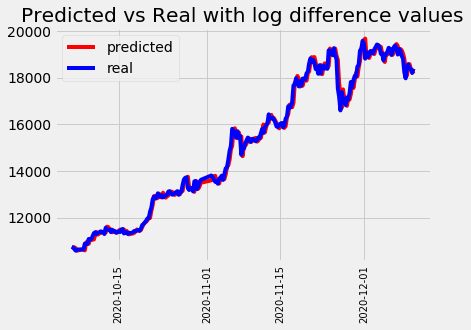

In [80]:
plotRealvsPredAdaBoost('BTC-USD')

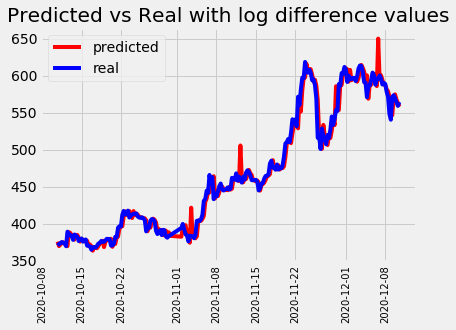

In [81]:
plotRealvsPredAdaBoost('ETH-USD')

In [132]:
vals = []
for sym in rbh:
    for dowHod in [True, False]:
        for oneHot in [True,False]:
            for d in range(3,4):
                for s in range(5,7):
                    for lr in [.05, 0.15,.35]:
                        for ne in [50, 200,	800, 950]:
                            vals.append(timeSeriesPred(sym, d, cols[:s], dowHod, oneHot, ne, lr))

In [130]:
results = pd.DataFrame(vals)
results.columns = ['symbol', 'mse', 'accuracy', 'depth', 'len', 'dow hod included?', 'one hot?','number estimators', 'learning rate', 'current', 'predicted']

In [131]:
idx = results.groupby('symbol')['accuracy'].transform(max) == results['accuracy']
results[idx].sort_values('accuracy', ascending = False)

,symbol,mse,accuracy,depth,len,dow hod included?,one hot?,number estimators,learning rate,current,predicted
90,BTC-USD,18.97,0.649038,3,6,False,False,800,0.15,18377.54,18378.54
115,ETH-USD,1.35,0.558974,3,6,True,True,950,0.15,564.16,565.16
